# Background

Hi! Welcome to the Notebook section for solubility prediction using Machine Learning.

In this notebook, you'll find my personal scratchpad where I'll be exploring and experimenting with different approaches to predict solubility. I'd like to keep it less formal, so you'll see lots of prints and intermediate steps as I work through the problem.

# Introduction

Solubility prediction is a crucial task in pharmaceutical chemistry that involves estimating the solubility of chemical compounds in a given solvent or medium. It plays a fundamental role in drug discovery and development, as the solubility of a drug directly impacts its bioavailability, formulation, and pharmacological activity. A high solubility of a drug compound ensures efficient dissolution in biological fluids, allowing for better absorption and therapeutic effects. On the other hand, poor solubility can lead to reduced drug efficacy, delayed onset of action, and potential safety concerns.

Traditionally, measuring the solubility of a compound involved time-consuming and expensive experimental methods, which becomes impractical with the vast number of compounds in molecular screening libraries. To overcome this challenge, researchers have turned to computational methods, including molecular simulation, quantum calculations, and empirical models.

Molecular simulation techniques involve computationally intensive calculations, while quantum-based methods require a higher level of theory and significant computing power. Empirical models, on the other hand, leverage machine learning algorithms to predict solubility based on training data of known compounds. These models offer faster predictions but may struggle to generalize beyond the training set.

This project aims to build upon previous solubility prediction models and introduce improvements to enhance accuracy and performance. The objective is to achieve more robust and reliable solubility predictions. Additionally, this project strives to provide user-friendly tools that simplify the prediction process, allowing pharmaceutical researchers to conveniently access and utilize the solubility predictor in their drug discovery endeavors. By combining advanced algorithms with ease of use, this initiative aims to empower researchers with a powerful tool for making informed decisions and accelerating drug development processes.

# Prerequisites

**Note: This Jupyter notebook contains certain sections that require running it locally on your machine. These sections involve file paths and dependencies that are specific to the local environment. If you are running this notebook in a different environment or platform (e.g., Google Colab), you may encounter errors related to file paths.**

To ensure smooth execution and accurate results, the notebook includes an automated folder creation in the same directory as this notebook and places the required datasets/models inside it.

Please be aware that certain parts of the notebook may not work as expected in alternative environments, and it is recommended to run those sections locally for the most accurate results.

### Setting up the Environment

Before we begin, ensure you have the required Python libraries installed in your Jupyter Notebook environment. You can use the following code to install the necessary libraries:

In [3]:
# Check if the required libraries are already installed
try:
    # For data processing
    import pandas as pd
    import numpy as np
    import opendatasets as od
    
    # For plotting
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # For training the models
    import sklearn
    import tensorflow as tf
    import xgboost as xgb
    
    # For cheminformatics library
    import rdkit
    import mordred
except ImportError:
    # If any of the libraries are not installed, install them using pip
    %pip install pandas numpy opendatasets matplotlib seaborn scikit-learn tensorflow xgboost rdkit mordred


The following are libraries that we would like to import

In [4]:
# For systems
import os
from pathlib import Path
import requests
import zipfile
import shutil
import inspect
import joblib
import json

# For data processing
import pandas as pd
import numpy as np
import opendatasets as od

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For training the models
import sklearn
import tensorflow as tf
import xgboost as xgb

# For cheminformatics library
import rdkit
import mordred

### Setting up Global Variables and Seeds

This is just for convenience and also for reproducibility.

In [5]:
DIR_PATH = Path('__file__').parent.absolute()
DATASETS_DIR_NAME = "datasets"
MODELS_DIR_NAME = "models"
DATASET_PATH_AQSOLDB = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/AqSolDB.csv")
DATASET_PATH_BIGSOLDB = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/BigSolDB.csv")
DATASET_PATH_SOMASDB = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/SomasDB.csv")
DATASET_PATH_MLDL_ZIP = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/MLDLDB.zip")
DATASET_PATH_MLDL_LOOSE_SET = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/MLDL_Loose_set.csv")
DATASET_PATH_MLDL_TIGHT_SET = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/MLDL_Tight_set.csv")
DATASET_PATH_MLDL_TRAINING_SET = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/MLDL_Training_sets.csv")
DATASET_PATH_FULL_DATASET_BASIC = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/full_dataset_basic.csv")

RANDOM_SEED = 42

SMILES_SOLUTE = "SMILES"
SMILES_SOLVENT = "SMILES_Solvent"
TEMPERATURE = "Temperature"
SOLUBILITY = "Solubility"
OCCURRENCES = "Occurrences" # Temporary column to average them during preprocessing

DEFAULT_TEMPERATURE = 298.15
DEFAULT_SOLVENT = "O" # Water SMILES String

# Set seeds
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Download Datasets

The datasets that we will be using are:

1. AqSolDB: Sorkun, M.C., Khetan, A. & Er, S. AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds. Sci Data 6, 143 (2019). https://doi.org/10.1038/s41597-019-0151-1
2. BigSolDB: Krasnov L, Mikhaylov S, Fedorov M, Sosnin S. BigSolDB: Solubility Dataset of Compounds in Organic Solvents and Water in a Wide Range of Temperatures. ChemRxiv 2023. https://doi.org/10.26434/chemrxiv-2023-qqslt
3. MLDLDataset (Blinded Predictions and Post Hoc Analysis of the Second Solubility Challenge Data): Conn, J. G. M.; Carter, J. W.; Conn, J. J. A.; Subramanian, V.; Baxter, A.; Engkvist, O.; Llinas, A.; Ratkova, E. L.; Pickett, S. D.; McDonagh, J. L.; Palmer, D. S. Blinded Predictions and Post Hoc Analysis of the Second Solubility Challenge Data: Exploring Training Data and Feature Set Selection for Machine and Deep Learning Models. J. Chem. Inf. Model. 2023, 63 (4), 1099-1113. https://doi.org/10.1021/acs.jcim.2c01189.
4. SomasDB: Gao, P.; Andersen, A.; Sepulveda, J. et al. SOMAS: a platform for data-driven material discovery in redox flow battery development. Sci Data 2022, 9, 740. https://doi.org/10.1038/s41597-022-01814-4

Let's get them and put them in datasets folder. 

**IMPORTANT NOTE**

1. You will have to setup some Kaggle credentials first though since we will be using Kaggle for AqSolDB.
2. Downloading zipped dataset from pubs.acs using script might not be legal in some countries, so we will only leave the zipped file link
https://pubs.acs.org/doi/suppl/10.1021/acs.jcim.2c01189/suppl_file/ci2c01189_si_001.zip. Then, you will have to rename the zipepd dataset into MLDLDB.zip in the dataset folder

In [49]:
# Create the directory if it doesn't exist
if not os.path.exists(DATASETS_DIR_NAME):
    print(f"Directory {DATASETS_DIR_NAME} is not found, creating a new one")
    os.makedirs(DATASETS_DIR_NAME)

# Download BigSolDB and SomasDB
def download_dataset(dataset_name, dataset_path, dataset_url):
    # dataset_name is only for debugging...
    # Already exists, no need to write again
    if os.path.exists(dataset_path):
        print(f"Dataset {dataset_name} already exists. Skipping download.")
    else:
        response = requests.get(dataset_url)
        if response.status_code == 200:
            with open(dataset_path, 'wb') as file:
                file.write(response.content)
            print(f"Dataset {dataset_name} has been downloaded successfully!")
        else:
            print(f"Failed to download the dataset {dataset_name}!")

download_dataset("BigSolDB", DATASET_PATH_BIGSOLDB, "https://zenodo.org/record/6984601/files/BigSolDB.csv?download=1")
download_dataset("SomasDB", DATASET_PATH_SOMASDB, "https://ndownloader.figstatic.com/files/38256831")

# Download AqSolDB (through Kaggle)
if not os.path.exists(DATASET_PATH_AQSOLDB):
    od.download("https://www.kaggle.com/datasets/sorkun/aqsoldb-a-curated-aqueous-solubility-dataset", DATASET_PATH_AQSOLDB)
    print("Dataset AqSolDB has been downloaded successfully!")
else:
    print("Dataset AqSolDB already exists. Skipping download.")

# Unzip MLDL Dataset, this will be in zip
if os.path.exists(DATASET_PATH_MLDL_ZIP):
    # Unzip the dataset zip file
    with zipfile.ZipFile(DATASET_PATH_MLDL_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATASETS_DIR_NAME)
        print('MLDL dataset has been unzipped successfully!')

    # Copy and rename the files
    old_dataset_dir = os.path.join(DATASETS_DIR_NAME, "datasets")
    old_loose_set = os.path.join(old_dataset_dir, "Loose_set.csv")
    old_tight_set = os.path.join(old_dataset_dir, "Tight_set.csv")
    old_training_set = os.path.join(old_dataset_dir, "Training_sets.csv")
    
    if not os.path.exists(DATASET_PATH_MLDL_LOOSE_SET):
        shutil.copyfile(old_loose_set, DATASET_PATH_MLDL_LOOSE_SET)
    if not os.path.exists(DATASET_PATH_MLDL_LOOSE_SET):
        shutil.copyfile(old_tight_set, DATASET_PATH_MLDL_TIGHT_SET)
    if not os.path.exists(DATASET_PATH_MLDL_LOOSE_SET):
        shutil.copyfile(old_training_set, DATASET_PATH_MLDL_TRAINING_SET)

else:
    print("MLDLDB.zip file is not found, please download it!")

Dataset BigSolDB already exists. Skipping download.
Dataset SomasDB already exists. Skipping download.
Dataset AqSolDB already exists. Skipping download.
MLDLDB.zip file is not found, please download it!


All set! Let's explore the data that we have.

# Data Exploration

Our main objective (in this notebook) is to predict solubility in logS unit based on the SMILES string of the solute.
We assume that the solvent being used would be $H_2O$ under temperature of 298.15 K.

The main idea here is that we want to combine 4 different datasets into one big dataset that can be used for training and testing the model.
However, there would be challenges on how to combine the different datasets, as they may be collected under different units or column names

Therefore, first, let's try to take a quick peek on each dataset that we have.

### Quick Peek on each Dataset

The goal here is to check what columns that they have and what are the assumptions being used when collecting the dataset.

#### 1. AqSolDB

Based on the paper, AqSolDB is collected under assumption that it is taken under standard temperature (298.15 K) and performed under $H_2O$ as the solvent, which matches our assumptions.

In [58]:
aq_sol_df = pd.read_csv(DATASET_PATH_AQSOLDB)
print("Printing AqSolDB info")
print(aq_sol_df.info())

Printing AqSolDB info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9982 non-null   object 
 1   Name                 9982 non-null   object 
 2   InChI                9982 non-null   object 
 3   InChIKey             9982 non-null   object 
 4   SMILES               9982 non-null   object 
 5   Solubility           9982 non-null   float64
 6   SD                   9982 non-null   float64
 7   Ocurrences           9982 non-null   int64  
 8   Group                9982 non-null   object 
 9   MolWt                9982 non-null   float64
 10  MolLogP              9982 non-null   float64
 11  MolMR                9982 non-null   float64
 12  HeavyAtomCount       9982 non-null   float64
 13  NumHAcceptors        9982 non-null   float64
 14  NumHDonors           9982 non-null   float64
 15  NumHeteroatoms  

In [ ]:
aq_sol_df.head()

Some columns that needs to be noted:
- SMILES is the SMILES string of the solute, that is what we want for the input.
- Solubility is our target variable, the unit is already in logS.
- SD and Ocurrences indicate that the solubility for the same SMILES may have been experimented multiple times

The rest of the columns are 2D descriptors of the SMILES calculated using RDKit, so we should keep that in mind as well.
We don't need to worry about "Name", "InChI", and "InChIKey" columns as they are used for identifier purposes only.

#### 2. BigSolDB

BigSolDB dataset provides solubility for based on the solute, solvent, and temperatures.

In [59]:
big_sol_df = pd.read_csv(DATASET_PATH_BIGSOLDB)
print("Print BigSolDB info")
print(big_sol_df.info())

Print BigSolDB info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SMILES          54273 non-null  object 
 1   T,K             54273 non-null  float64
 2   Solubility      54273 non-null  float64
 3   Solvent         54273 non-null  object 
 4   SMILES_Solvent  54273 non-null  object 
 5   Source          54273 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.5+ MB
None
Print BigSolDB first 5 rows
                   SMILES     T,K  Solubility   Solvent SMILES_Solvent  \
0  ON(Cc1ccccc1)Cc1ccccc1  273.15    0.001261  methanol             CO   
1  ON(Cc1ccccc1)Cc1ccccc1  279.15    0.001713  methanol             CO   
2  ON(Cc1ccccc1)Cc1ccccc1  283.45    0.002094  methanol             CO   
3  ON(Cc1ccccc1)Cc1ccccc1  289.05    0.002760  methanol             CO   
4  ON(Cc1ccccc1)Cc1ccccc1  293.05    0.003327  methanol  

In [ ]:
big_sol_df.head()

Notice that they have "Solvent" and "Temperature" column.
Since in the beginning we assumed that we would only want to predict solubility with $H_2O$ as the solvent under standard temperature (298.15 K), it's plausible to filter rows based on these two conditions.

However, there is one major issue if we want to do that: logS is a measure of solubility under **$H_2O$** as a solvent, thus it would make sense that the solubility being measured will be under different units, as they have results from solvents other than $H_2O$. In fact, they are using molar fraction, and it is impossible to get the logS value given their table information.

Therefore, we will leave the dataset here for future usage.

#### 3. MLDL Dataset

Based on the paper, MLDL Dataset is collected under assumption that it is taken under standard temperature (298.15 K) and performed under $H_2O$ as the solvent, which matches our assumptions.
Note that Loose, Tight, and Training datasets all have same columns, and they are all unique to each other. We will later combine these datasets.

In [ ]:
MLDL_loose_df = pd.read_csv(DATASET_PATH_MLDL_LOOSE_SET)
MLDL_tight_df = pd.read_csv(DATASET_PATH_MLDL_TIGHT_SET)
MLDL_train_df = pd.read_csv(DATASET_PATH_MLDL_TRAINING_SET)
print("Print MLDLDataset info")
print(MLDL_loose_df.info())

In [ ]:
MLDL_loose_df.head()

Other than SMILES and Solubility columns, we can see that the features come from RDKit calculation and mordred. We will consider this for later.
Another thing is that the first row is used as a column name, so we would need to remove that or replace the column names with first row.

In [61]:
MLDL_actual_columns = MLDL_loose_df.iloc[[0]].values

# Iterate over the column names and print them
print("Printing the columns used for MLDLDataset")
for col_name in MLDL_actual_columns[0]:
    print(col_name)

Printing the columns used for MLDLDataset
ID
Name
SMILES
Solubility
MaxEStateIndex
MinEStateIndex
MaxAbsEStateIndex
MinAbsEStateIndex
qed
MolWt
HeavyAtomMolWt
ExactMolWt
NumValenceElectrons
NumRadicalElectrons
MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
FpDensityMorgan1
FpDensityMorgan2
FpDensityMorgan3
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
BalabanJ
BertzCT
Chi0
Chi0n
Chi0v
Chi1
Chi1n
Chi1v
Chi2n
Chi2v
Chi3n
Chi3v
Chi4n
Chi4v
HallKierAlpha
Kappa1
Kappa2
LabuteASA
PEOE_VSA1
PEOE_VSA10
PEOE_VSA11
PEOE_VSA12
PEOE_VSA13
PEOE_VSA14
PEOE_VSA2
PEOE_VSA3
PEOE_VSA4
PEOE_VSA5
PEOE_VSA6
PEOE_VSA7
PEOE_VSA8
PEOE_VSA9
SMR_VSA1
SMR_VSA10
SMR_VSA2
SMR_VSA3
SMR_VSA4
SMR_VSA5
SMR_VSA6
SMR_VSA7
SMR_VSA8
SMR_VSA9
SlogP_VSA1
SlogP_VSA10
SlogP_VSA11
SlogP_VSA12
SlogP_VSA2
SlogP_VSA3
SlogP_VSA4
SlogP_VSA5
SlogP_VSA6
SlogP_VSA7
SlogP_VSA8
SlogP_VSA9
TPSA
EState_VSA1
EState_VSA10
EState_VSA11
EState_VSA2
EState_VS

#### 4. SomasDB

Based on the paper, MLDL Dataset is collected under assumption that the solvent used is $H_2O$, which matches our assumptions.
The dataset also includes multiple temperature. Since we only want the solubility when temperature is 298.15K, we will filter out the rest for now.
However, the paper mentioned that the solubility is measured using mg/L as the unit, while conventionally, we would use logS or mol/L as the unit.
Therefore, we would need to convert the solubility column from mg/L to mol/L later.

In [62]:
somas_df = pd.read_csv(DATASET_PATH_SOMASDB)
print("Print SomasDB info")
print(somas_df.info())

Print SomasDB info
                          Name              SMILES  Molar Mass   CAS Number  \
0           Tetrafluoromethane         C(F)(F)(F)F       88.00  000075-73-0   
1                      METHANE                   C       16.04  000074-82-8   
2             HEXAFLUOROETHANE  C(C(F)(F)F)(F)(F)F      138.01  000076-16-4   
3             TRIFLUOROMETHANE            C(F)(F)F       70.01  000075-46-7   
4  2.2.2-trifluoroacetonitrile       C(#N)C(F)(F)F       95.02  036443-68-2   

   Experimental Solubility in Water  Temperature  \
0                            18.800       298.15   
1                            22.000       298.15   
2                             7.780       298.15   
3                          4090.000       298.15   
4                             0.104       295.15   

                                Experiment Reference Datagroup  \
0                                  HORVATH.AL (1982)        G2   
1                         YALKOWSKY.SH ET AL. (2010)        G

In [ ]:
somas_df.head()

The attributes being used in this dataset can be calculated with RDKit or Mordred, except solvation energy, dipole moment, moelcular volume, molecular surface area, QXX, QYY, QZZ, HOMO, LUMO, and gap. We can certainly calculate these properties, however, these would need long computations. Since we are looking for a model that is quick enough to make a prediction, we will skip these features for now.

### Combining All Datasets

Now that we have taken a peek on all datasets, the idea would be to drop all columns except SMILES and Solubility, and we would use RDKit and mordred to calculate some properties based on the SMILES string. This is similar to how MLDLDataset was generated. However, first, we might need to rename some columns so they can all be consistent.

Another thing to consider is that we might have some intersections between datasets, so we will add "Occurrences" column to merge these rows.

In [63]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to convert mgL to default unit of logS
def convert_mgL_to_logS(smiles_string, sol_in_mgL):
    mol_from_smiles = Chem.MolFromSmiles(smiles_string)
    return np.log10(sol_in_mgL / 1000 / Descriptors.ExactMolWt(mol_from_smiles))

# Preprocess AqSolDB
aq_sol_df = aq_sol_df.rename(columns={"SMILES": SMILES_SOLUTE, "Solubility": SOLUBILITY,
                        "Ocurrences": OCCURRENCES}, errors="raise")
aq_sol_df = aq_sol_df[[SMILES_SOLUTE, SOLUBILITY, OCCURRENCES]]


# Preprocess SomasDB
somas_df = somas_df.rename(columns={"SMILES": SMILES_SOLUTE, "Experimental Solubility in Water": SOLUBILITY,
                        "Temperature": TEMPERATURE}, errors="raise")
somas_df = somas_df[[SMILES_SOLUTE, SOLUBILITY, TEMPERATURE]]
somas_df[OCCURRENCES] = 1
somas_df[TEMPERATURE] = somas_df[TEMPERATURE].astype(float)
somas_df = somas_df[somas_df[TEMPERATURE] == DEFAULT_TEMPERATURE]
somas_df = somas_df.drop(columns=[TEMPERATURE])     
# Recall that we need to convert from mg/L to mol/L for Solubility column
somas_df[SOLUBILITY] = somas_df.apply(lambda row: convert_mgL_to_logS(row[SMILES_SOLUTE], row[SOLUBILITY]), axis=1)

# Preprocess MLDLDB
MLDL_df = pd.DataFrame(columns=[SMILES_SOLUTE, SOLUBILITY])
for df in [MLDL_tight_df, MLDL_loose_df, MLDL_train_df]:
    df = df.rename(columns={"SMILES": SMILES_SOLUTE, "Solubility": SOLUBILITY}, errors="raise")
    df = df[[SMILES_SOLUTE, SOLUBILITY]]
    # First row is just a column name
    df = df.tail(-1)
    MLDL_df = pd.concat([MLDL_df, df], ignore_index=True)

MLDL_df[SOLUBILITY] = MLDL_df[SOLUBILITY].astype(float)
MLDL_df[OCCURRENCES] = 1

In [72]:
# Now combine all datasets, eliminate duplicated SMILES from many datasets by averaging them
merged_df = pd.concat([aq_sol_df, somas_df, MLDL_df], ignore_index=True)
groupby_columns = [SMILES_SOLUTE]

# This does not do interconversion between logs in order to minimize precision error
weighted_mean_sol = lambda x: (x[SOLUBILITY] * x[OCCURRENCES]).sum() / x[OCCURRENCES].sum()
new_sol_col = merged_df.groupby(groupby_columns).apply(weighted_mean_sol).reset_index()
new_sol_col.rename(columns={0: SOLUBILITY}, inplace=True)
merged_df = merged_df.drop(columns=[OCCURRENCES, SOLUBILITY])
merged_df = merged_df.drop_duplicates(subset=groupby_columns).merge(new_sol_col, on=groupby_columns, how='inner')

# Printing to check what is the merged dataframe looks like
print("Printing combined Dataframe info")
print(merged_df.info())

Printing combined Dataframe info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 0 to 20884
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SMILES      20885 non-null  object 
 1   Solubility  20885 non-null  float64
dtypes: float64(1), object(1)
memory usage: 489.5+ KB
None
Printing combined Dataframe first 5 rows
                                              SMILES  Solubility
0                [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C   -3.616127
1                               O=C1Nc2cccc3cccc1c23   -3.254767
2                                    Clc1ccc(C=O)cc1   -2.177078
3  [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...   -3.924409
4  C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...   -4.662065


In [ ]:
merged_df.head()

In [73]:
# Just a check that the SMILES are unique
print(merged_df[SMILES_SOLUTE].nunique() == len(merged_df))

True


### Adding Features

The strategy here is to calculate our own set of features using RDKit and Mordred.
For RDKit, we can just reuse properties that have been curated from MLDLDataset.
For Mordred, we will just use their API to calculate for each SMILES.
In case there are overlaps of columns, we will remove the duplicated features (potentially from RDKit and Mordred)

In [ ]:
from rdkit.Chem import Descriptors
from mordred import Calculator, descriptors

def calculate_property_rdkit(smiles, property_name):
    molecule = Chem.MolFromSmiles(smiles)
    property_value = getattr(Descriptors, property_name)(molecule)
    return property_value

def add_rdkit_features(df):
    # MLDLDB has all the attributes, but first filter to get the ones that are available in RDKit
    mldl_df = pd.read_csv(DATASET_PATH_MLDL_LOOSE_SET)
    first_row = mldl_df.iloc[[0]].values
    attribute_names = []
    for col_ind in range(len(mldl_df.columns)):
        if "RDKit" in mldl_df.columns[col_ind]:
            attribute_names.append(first_row[0][col_ind])

    for attr_name in attribute_names:
        for _, module in inspect.getmembers(Chem, inspect.ismodule):
            if hasattr(module, attr_name):
                df[attr_name] = df[SMILES_SOLUTE].apply(calculate_property_rdkit, args=(attr_name,))
                break

    return df

def add_mordred_features(df, ignore_3D=True):
    # Use Mordred to get all the attributes
    calc = Calculator(descriptors, ignore_3D=ignore_3D)
    smiles_data = [Chem.MolFromSmiles(smi) for smi in df[SMILES_SOLUTE].to_list()[:]]
    generated_df = calc.pandas(smiles_data)
    df = pd.concat([df, generated_df], axis=1, join='outer')
    return df

def remove_duplicate_features(df):
    # Remove duplicated columns (potentially from RDKit and Mordred overlap)
    duplicate_columns = df.columns[df.columns.duplicated()]
    if len(duplicate_columns) > 0:
        print("Duplicate column names found, averaging them")

        # Create a new DataFrame with only the duplicated columns
        duplicated_df = df[duplicate_columns]

        # Check if the values in the duplicated columns are the same for each row
        if not duplicated_df.apply(lambda col: col.nunique(), axis=1).eq(1).all():
            # Resolve by averaging for each set of duplicated columns
            averaged_columns = {col_name: duplicated_df[col_name].mean(axis=1) for col_name in duplicated_df}
            df = df.drop(columns=duplicate_columns)
            for col_name, averaged_values in averaged_columns.items():
                df[col_name] = averaged_values
    
    return df


final_df = add_rdkit_features(merged_df)
final_df = add_mordred_features(final_df)
final_df = remove_duplicate_features(final_df)

print("Printing final basic Dataframe info")
print(final_df.info())

In [ ]:
final_df.head()

There we have it! This dataset may contain dirty rows and features that are highly correlated or somewhat not useful. We will investigate that soon.

#### Optional - Saving Dataset as CSV

If you would like, you can save this dataset as a CSV for later use by running the following code.

In [75]:
# Write to CSV
if not os.path.exists(DATASET_PATH_FULL_DATASET_BASIC):
    final_df.to_csv(DATASET_PATH_FULL_DATASET_BASIC, index=False)
    print("Preprocessed DataFrame has been written to CSV successfully.")

Preprocessed DataFrame has been written to CSV successfully.


# Cleaning the Data

Recall, what we know from the dataset are: SMILES for the solute, Solubility, and features that are RDKit and Mordred. We also know that the features do not have duplicated column name, however, this does not necessarily mean that there are duplicated features. Let's start cleaning step by step.

In [5]:
# Just a checkpoint, in case the dataset will be modified further
# analyze_df = final_df.copy(True)
analyze_df = pd.read_csv(DATASET_PATH_FULL_DATASET_BASIC)

Columns (157,158,159,160,161,162,163,164,165,166,167,168,206,207,208,209,210,211,212,213,214,242,243,244,245,246,247,248,249,250,260,261,262,263,264,265,266,267,268,288,289,290,291,292,293,297,298,299,300,301,302,305,306,307,308,309,310,311,315,316,317,318,319,320,324,325,326,327,328,329,333,334,335,336,337,338,341,342,343,344,345,346,347,351,352,353,354,355,356,359,360,361,362,363,364,365,369,370,371,372,373,374,378,379,380,381,382,383,386,387,388,389,390,391,392,393,394,413,414,415,416,417,418,419,420,421,449,450,451,452,453,454,455,456,457,467,468,469,470,471,472,473,474,475,494,495,496,497,498,499,500,504,505,506,507,508,509,513,514,515,516,517,518,521,522,523,524,525,526,527,531,532,533,534,535,536,540,541,542,543,544,545,549,550,551,552,553,554,557,558,559,560,561,562,563,567,568,569,570,571,572,575,576,577,578,579,580,581,585,586,587,588,589,590,594,595,596,597,598,599,602,603,604,605,606,607,610,611,612,613,614,615,618,619,620,621,622,623,626,627,628,629,630,631,634,635,636,637

### 1. Investigate mixed-numeric columns

First, let's check the mixed-numeric (a mix of numeric and non-numeric) features. We want to check what are the values of these features.

In [6]:
# Get the boolean mask for columns that are not entirely numeric
non_numeric_columns = analyze_df.applymap(pd.to_numeric, errors='coerce').isna().all()
columns_to_process = analyze_df.columns[~non_numeric_columns]

# Initialize a dictionary to store non-numeric values and their counts
mixed_numeric_values_counts = {}

for column in columns_to_process:
    # Count the occurrences of each mixed-numeric value
    mixed_numeric_values = analyze_df[column][~analyze_df[column].apply(pd.to_numeric, errors='coerce').notna()]
    mixed_numeric_count = mixed_numeric_values.value_counts()
    if mixed_numeric_count.sum() > 0:
        # Append the counts to the dictionary
        mixed_numeric_values_counts[column] = mixed_numeric_count

In [7]:
print(f"There are {len(mixed_numeric_values_counts)} columns to be considered")
for column, counts in mixed_numeric_values_counts.items():
    print(f"Column '{column}':")
    for value, count in counts.items():
        print(f"{value}: {count}")
    print()

There are 830 columns to be considered
Column 'SpAbs_A':
multiple fragments (SpAbs_A/SpAbs): 1098

Column 'SpMax_A':
multiple fragments (SpMax_A/SpMax): 1098

Column 'SpDiam_A':
multiple fragments (SpDiam_A/SpDiam): 1098

Column 'SpAD_A':
multiple fragments (SpAD_A/SpAD): 1098

Column 'SpMAD_A':
multiple fragments (SpMAD_A/SpMAD): 1098

Column 'LogEE_A':
multiple fragments (LogEE_A/LogEE): 1098

Column 'VE1_A':
multiple fragments (VE1_A/VE1): 1098

Column 'VE2_A':
multiple fragments (VE2_A/VE2): 1098

Column 'VE3_A':
multiple fragments (VE3_A/VE3): 1098

Column 'VR1_A':
multiple fragments (VR1_A/VR1): 1098

Column 'VR2_A':
multiple fragments (VR2_A/VR2): 1098

Column 'VR3_A':
multiple fragments (VR3_A/VR3): 1098
divide by zero encountered in log (VR3_A/VR3): 37

Column 'ATS0s':
missing intrinsic state for ['Na'] (ATS0s/Props): 326
missing intrinsic state for ['Cl'] (ATS0s/Props): 58
missing intrinsic state for ['K'] (ATS0s/Props): 41
missing intrinsic state for ['Ca'] (ATS0s/Props): 38

The code above should populate columns that contain mixed-numeric values per column, along with the counts. Let's try to see how many columns are being considered and their values.

In [8]:
print(f"There are {len(mixed_numeric_values_counts)} columns to be considered")
for column, counts in mixed_numeric_values_counts.items():
    print(f"Column '{column}':")
    for value, count in counts.items():
        print(f"{value}: {count}")
    print()

There are 830 columns to be considered
Column 'SpAbs_A':
multiple fragments (SpAbs_A/SpAbs): 1098

Column 'SpMax_A':
multiple fragments (SpMax_A/SpMax): 1098

Column 'SpDiam_A':
multiple fragments (SpDiam_A/SpDiam): 1098

Column 'SpAD_A':
multiple fragments (SpAD_A/SpAD): 1098

Column 'SpMAD_A':
multiple fragments (SpMAD_A/SpMAD): 1098

Column 'LogEE_A':
multiple fragments (LogEE_A/LogEE): 1098

Column 'VE1_A':
multiple fragments (VE1_A/VE1): 1098

Column 'VE2_A':
multiple fragments (VE2_A/VE2): 1098

Column 'VE3_A':
multiple fragments (VE3_A/VE3): 1098

Column 'VR1_A':
multiple fragments (VR1_A/VR1): 1098

Column 'VR2_A':
multiple fragments (VR2_A/VR2): 1098

Column 'VR3_A':
multiple fragments (VR3_A/VR3): 1098
divide by zero encountered in log (VR3_A/VR3): 37

Column 'ATS0s':
missing intrinsic state for ['Na'] (ATS0s/Props): 326
missing intrinsic state for ['Cl'] (ATS0s/Props): 58
missing intrinsic state for ['K'] (ATS0s/Props): 41
missing intrinsic state for ['Ca'] (ATS0s/Props): 38

The print statement blows up! Let's try to digest them one by one by selecting 

In [9]:
def filter_mixed_numeric_values_counts(mixed_numeric_values_counts, substrings):
    filtered_counts = {}
    for column, counts in mixed_numeric_values_counts.items():
        filtered_values = {value: count for value, count in counts.items() if any(substring in value.lower() for substring in substrings)}
        if len(filtered_values) > 0:
            filtered_counts[column] = filtered_values

    return filtered_counts

In [10]:
divide_error_counts = filter_mixed_numeric_values_counts(mixed_numeric_values_counts, ["divide", "division"])
print(f"There are {len(divide_error_counts)} columns that contain division by zero")
for column, counts in divide_error_counts.items():
    if counts:
        print(f"Column '{column}':")
        for value, count in counts.items():
            print(f"{value}: {count}")
        print()

There are 55 columns that contain division by zero
Column 'VR3_A':
divide by zero encountered in log (VR3_A/VR3): 37

Column 'VR3_DzZ':
divide by zero encountered in log (VR3_DzZ/VR3): 37

Column 'VR3_Dzm':
divide by zero encountered in log (VR3_Dzm/VR3): 37

Column 'VR3_Dzv':
divide by zero encountered in log (VR3_Dzv/VR3): 37

Column 'VR3_Dzse':
divide by zero encountered in log (VR3_Dzse/VR3): 28

Column 'VR3_Dzpe':
divide by zero encountered in log (VR3_Dzpe/VR3): 37

Column 'VR3_Dzare':
divide by zero encountered in log (VR3_Dzare/VR3): 34

Column 'VR3_Dzp':
divide by zero encountered in log (VR3_Dzp/VR3): 37

Column 'VR3_Dzi':
divide by zero encountered in log (VR3_Dzi/VR3): 37

Column 'AXp-1d':
float division by zero (AXp-1d): 149

Column 'AXp-2d':
float division by zero (AXp-2d): 198

Column 'AXp-3d':
float division by zero (AXp-3d): 528

Column 'AXp-4d':
float division by zero (AXp-4d): 978

Column 'AXp-5d':
float division by zero (AXp-5d): 1632

Column 'AXp-6d':
float divisio

These features are unstable when being calculated, thus might not be a good feature to be calculated from SMILES when being used for predictions. Therefore, these 55 features will be removed later.

Let's put these features aside and continue looking.

In [11]:
exclude_divide_zero_counts = {column: counts for column, counts in mixed_numeric_values_counts.items() if column not in divide_error_counts.keys()}
missing_invalid_counts = filter_mixed_numeric_values_counts(exclude_divide_zero_counts, ["missing", "invalid value"])
print(f"There are {len(missing_invalid_counts)} columns that contain missing/invalid substrings")
for column, counts in missing_invalid_counts.items():
    if counts:
        print(f"Column '{column}':")
        for value, count in counts.items():
            print(f"{value}: {count}")
        print()

There are 492 columns that contain missing/invalid substrings
Column 'ATS0s':
missing intrinsic state for ['Na'] (ATS0s/Props): 326
missing intrinsic state for ['Cl'] (ATS0s/Props): 58
missing intrinsic state for ['K'] (ATS0s/Props): 41
missing intrinsic state for ['Ca'] (ATS0s/Props): 38
missing intrinsic state for ['Zn'] (ATS0s/Props): 32
missing intrinsic state for ['H', 'Cl'] (ATS0s/Props): 25
missing intrinsic state for ['Cl', 'H'] (ATS0s/Props): 20
missing intrinsic state for ['Li'] (ATS0s/Props): 17
missing intrinsic state for ['N'] (ATS0s/Props): 15
missing intrinsic state for ['Co'] (ATS0s/Props): 14
missing intrinsic state for ['Ba'] (ATS0s/Props): 14
missing intrinsic state for ['Br'] (ATS0s/Props): 13
missing intrinsic state for ['Al'] (ATS0s/Props): 11
missing intrinsic state for ['Cu'] (ATS0s/Props): 9
missing intrinsic state for ['Sr'] (ATS0s/Props): 9
missing intrinsic state for ['Mn'] (ATS0s/Props): 9
missing intrinsic state for ['Fe'] (ATS0s/Props): 8
missing intrinsi

These features are not reliable as they are either:
1. Invalid value encountered, which may ruin prediction if this feature is used.
2. Missing intrinsic state, EN (electronegativity), or charge for certain atoms. Since we are not planning to limit our input to only certain atoms (as they would limit the usage of the model and hard to be generalize), we will consider these features as insignificant predictors.

Thus, we will further exclude these features.

In [12]:
exclude_previous_counts = {column: counts for column, counts in exclude_divide_zero_counts.items() if column not in missing_invalid_counts.keys()}
multi_frag_counts = filter_mixed_numeric_values_counts(exclude_previous_counts, ["multiple fragment"])
print(f"There are {len(multi_frag_counts)} columns that contain multiple fragment substrings")
for column, counts in multi_frag_counts.items():
    if counts:
        print(f"Column '{column}':")
        for value, count in counts.items():
            print(f"{value}: {count}")
        print()

There are 167 columns that contain multiple fragment substrings
Column 'SpAbs_A':
multiple fragments (SpAbs_A/SpAbs): 1098

Column 'SpMax_A':
multiple fragments (SpMax_A/SpMax): 1098

Column 'SpDiam_A':
multiple fragments (SpDiam_A/SpDiam): 1098

Column 'SpAD_A':
multiple fragments (SpAD_A/SpAD): 1098

Column 'SpMAD_A':
multiple fragments (SpMAD_A/SpMAD): 1098

Column 'LogEE_A':
multiple fragments (LogEE_A/LogEE): 1098

Column 'VE1_A':
multiple fragments (VE1_A/VE1): 1098

Column 'VE2_A':
multiple fragments (VE2_A/VE2): 1098

Column 'VE3_A':
multiple fragments (VE3_A/VE3): 1098

Column 'VR1_A':
multiple fragments (VR1_A/VR1): 1098

Column 'VR2_A':
multiple fragments (VR2_A/VR2): 1098

Column 'BCUTdv-1h':
multiple fragments (BCUTdv-1h): 1098

Column 'BCUTdv-1l':
multiple fragments (BCUTdv-1l): 1098

Column 'BCUTd-1h':
multiple fragments (BCUTd-1h): 1098

Column 'BCUTd-1l':
multiple fragments (BCUTd-1l): 1098

Column 'BCUTZ-1h':
multiple fragments (BCUTZ-1h): 1098

Column 'BCUTZ-1l':
mul

Multiple fragments refers to a ratio of two molecular descriptors (for example, SpAbs_A/SpAbs means ratio of sum of the absolute value of atomic-specifc Sanderson EN values, and sum of the absolute values of Sanderson EN values). These features are hard to represent as one feature; splitting into multiple features may further complicate the model and these multiple features would have high dependency on each other, so we can simply drop these features as well.

In [13]:
exclude_previous_two_counts = {column: counts for column, counts in exclude_previous_counts.items() if column not in multi_frag_counts.keys()}
empty_sequence_counts = filter_mixed_numeric_values_counts(exclude_previous_two_counts, ["empty sequence"])
print(f"There are {len(empty_sequence_counts)} columns with empty sequence substring")
for column, counts in empty_sequence_counts.items():
    print(f"Column '{column}':")
    for value, count in counts.items():
        print(f"{value}: {count}")
    print()

There are 110 columns with empty sequence substring
Column 'MAXsssB':
max() arg is an empty sequence (MAXsssB): 20868

Column 'MAXssssB':
max() arg is an empty sequence (MAXssssB): 20881

Column 'MAXsCH3':
max() arg is an empty sequence (MAXsCH3): 7764

Column 'MAXdCH2':
max() arg is an empty sequence (MAXdCH2): 20011

Column 'MAXssCH2':
max() arg is an empty sequence (MAXssCH2): 7322

Column 'MAXtCH':
max() arg is an empty sequence (MAXtCH): 20701

Column 'MAXdsCH':
max() arg is an empty sequence (MAXdsCH): 17818

Column 'MAXaaCH':
max() arg is an empty sequence (MAXaaCH): 10253

Column 'MAXsssCH':
max() arg is an empty sequence (MAXsssCH): 12135

Column 'MAXddC':
max() arg is an empty sequence (MAXddC): 20788

Column 'MAXtsC':
max() arg is an empty sequence (MAXtsC): 20181

Column 'MAXdssC':
max() arg is an empty sequence (MAXdssC): 9397

Column 'MAXaasC':
max() arg is an empty sequence (MAXaasC): 10324

Column 'MAXaaaC':
max() arg is an empty sequence (MAXaaaC): 18808

Column 'MAXss

These are errors due to mordred not being able to find a sequence of Electrotopological State Indices for Atom Types (referred to as E-state) to take min/max on. They are useful for database characterization, molecular similarity analysis, and QSAR, however the missing values are a lot in this case, so these features are very unstable to be calculated upon. Moving on!

In [14]:
remaining_counts = {column: counts for column, counts in exclude_previous_two_counts.items() if column not in empty_sequence_counts.keys()}
print(f"There are {len(remaining_counts)} columns remaining")
for column, counts in remaining_counts.items():
    print(f"Column '{column}':")
    for value, count in counts.items():
        print(f"{value}: {count}")
    print()

There are 6 columns remaining
Column 'HybRatio':
there are no sp3 and sp2 carbons (HybRatio): 347

Column 'Xp-0d':
some properties less then or equal to 0 (Xp-0d): 953

Column 'AXp-0d':
some properties less then or equal to 0 (AXp-0d): 953

Column 'Xp-0dv':
some properties less then or equal to 0 (Xp-0dv): 695

Column 'AXp-0dv':
some properties less then or equal to 0 (AXp-0dv): 695

Column 'Vabc':
unknown atom type (Vabc): 1084



There are 6 remaining columns to be considered:
- HybRatio is for hybridization ratio. But there are compounds being used in pharmaceutical applications that may not have both sp3 and sp2 carbons, for instance ethanolamine (single carbon atom bonded to three hydrogen atoms (sp3 hybridization) and a nitrogen atom (sp3 hybridization)), so we will exclude this feature.
- The next 4 features are related to Chi-connectivity that are related to molecular descriptors for QSAR studies. However, there could be many reasons for these errors, for example invalid molecules that may have invalid descriptor values or the path length itself is limited. For now, we will exclude these features.
- Unknown atom type is an error so this might not be good in terms of using this feature for prediction.

Thus, we can come to conclusion that we will exclude all mixed-numeric features.

In [15]:
analyze_df = analyze_df.drop(columns=list(mixed_numeric_values_counts.keys()))
print("Printing new Dataframe info")
print(analyze_df.info())

Printing new Dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Columns: 936 entries, SMILES to VSA_EState9
dtypes: bool(2), float64(469), int64(402), object(63)
memory usage: 148.9+ MB
None


### 2. Investigate non-numeric columns

Now, let's check the non-numeric column features (except SMILES). We want to check what are the values of these features.

In [16]:
# Get the boolean mask for columns that are not entirely numeric
non_numeric_columns = analyze_df.applymap(pd.to_numeric, errors='coerce').isna().all()
columns_to_process = analyze_df.columns[non_numeric_columns]
# Remove SMILES column, we don't want to analyze them
columns_to_process = columns_to_process.drop(SMILES_SOLUTE)

# Initialize a dictionary to store non-numeric values and their counts
non_numeric_values_counts = {}

for column in columns_to_process:
    # Count the occurrences of each non-numeric value
    non_numeric_values = analyze_df[column][~analyze_df[column].apply(pd.to_numeric, errors='coerce').notna()]
    non_numeric_count = non_numeric_values.value_counts()
    if non_numeric_count.sum() > 0:
        # Append the counts to the dictionary
        non_numeric_values_counts[column] = non_numeric_count


In [17]:
print(f"There are {len(non_numeric_values_counts)} columns to be considered")
for column, counts in non_numeric_values_counts.items():
    print(f"Column '{column}':")
    for value, count in counts.items():
        print(f"{value}: {count}")
    print()

There are 62 columns to be considered
Column 'SpAbs_Dt':
module networkx has no attribute biconnected_component_subgraphs (SpAbs_Dt/SpAbs/mordred._matrix_attributes.Eigen(mordred.DetourMatrix.DetourMatrixCache())/mordred.DetourMatrix.DetourMatrixCache()): 19787
multiple fragments (SpAbs_Dt): 1098

Column 'SpMax_Dt':
module networkx has no attribute biconnected_component_subgraphs (SpAbs_Dt/SpAbs/mordred._matrix_attributes.Eigen(mordred.DetourMatrix.DetourMatrixCache())/mordred.DetourMatrix.DetourMatrixCache()): 19787
multiple fragments (SpMax_Dt): 1098

Column 'SpDiam_Dt':
module networkx has no attribute biconnected_component_subgraphs (SpAbs_Dt/SpAbs/mordred._matrix_attributes.Eigen(mordred.DetourMatrix.DetourMatrixCache())/mordred.DetourMatrix.DetourMatrixCache()): 19787
multiple fragments (SpDiam_Dt): 1098

Column 'SpAD_Dt':
module networkx has no attribute biconnected_component_subgraphs (SpAbs_Dt/SpAbs/mordred._matrix_attributes.Eigen(mordred.DetourMatrix.DetourMatrixCache())/mor

These features contain either:
- Values of "module networkx has no attribute biconnected_component_subgraphs" which seems like an internal error from Mordred, and the other value is multiple fragments, so we can drop these features as they will not be useful for prediction.
- Values of only empty sequence error (20885), which means that these features are not useful either.

Thus, we will drop these features.

In [18]:
analyze_df = analyze_df.drop(columns=list(non_numeric_values_counts.keys()))
print("Printing new Dataframe info")
print(analyze_df.info())

Printing new Dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Columns: 874 entries, SMILES to VSA_EState9
dtypes: bool(2), float64(469), int64(402), object(1)
memory usage: 139.0+ MB
None


### 3. Drop problematic numeric columns

Now we are left with only numeric columns. We should remove numeric columns that contains very large float number, infinity, and NaNs as they may introduce instability in training and prediction.

In [19]:
numeric_columns = analyze_df.select_dtypes(include='number').columns
unstable_mask = np.isnan(analyze_df[numeric_columns].values) | np.isinf(analyze_df[numeric_columns].values) | ~np.isfinite(analyze_df[numeric_columns])
unstable_columns = numeric_columns[unstable_mask.any(axis=0)]
analyze_df = analyze_df.drop(columns=unstable_columns)
print("Printing new Dataframe info")
print(analyze_df.info())

Printing new Dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Columns: 862 entries, SMILES to VSA_EState9
dtypes: bool(2), float64(457), int64(402), object(1)
memory usage: 137.1+ MB
None


### 4. Remove highly correlated columns

We will remove highly correlated columns where $R^2 = 1$ as they might be result of duplicated features.

In [20]:
correlation_matrix = analyze_df.drop(columns=[SMILES_SOLUTE]).corr()
correlation_matrix = correlation_matrix[abs(correlation_matrix) == 1]

# Keep track of columns to be removed
columns_to_remove = set()

# Get the number of columns (variables) in the DataFrame
num_vars = correlation_matrix.shape[1]

# Iterate over the rows and columns of the correlation matrix to print what are the variables.
for i in range(num_vars):
    for j in range(i + 1, num_vars):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) == 1.0:
            print(f"Variable Pair: ({correlation_matrix.index[i]}, {correlation_matrix.columns[j]}), Correlation: {correlation:.2f}")
            # WLOG removes first column (comes from RDKit)
            columns_to_remove.add(correlation_matrix.index[i])

Variable Pair: (TPSA, TopoPSA(NO)), Correlation: 1.00
Variable Pair: (FractionCSP3, FCSP3), Correlation: 1.00
Variable Pair: (NumHAcceptors, nHBAcc), Correlation: 1.00
Variable Pair: (NumHDonors, nHBDon), Correlation: 1.00
Variable Pair: (NumHeteroatoms, nHetero), Correlation: 1.00
Variable Pair: (NumRotatableBonds, nRot), Correlation: 1.00
Variable Pair: (RingCount, nRing), Correlation: 1.00
Variable Pair: (MolLogP, SLogP), Correlation: 1.00
Variable Pair: (MolMR, SMR), Correlation: 1.00
Variable Pair: (fr_Ar_NH, fr_Nhpyrrole), Correlation: 1.00
Variable Pair: (fr_Ar_NH, NaaNH), Correlation: 1.00
Variable Pair: (fr_Nhpyrrole, NaaNH), Correlation: 1.00
Variable Pair: (fr_halogen, nX), Correlation: 1.00
Variable Pair: (nAromBond, nBondsA), Correlation: 1.00
Variable Pair: (nBondsO, MWC01), Correlation: 1.00
Variable Pair: (n3Ring, n3ARing), Correlation: 1.00
Variable Pair: (n4Ring, n4ARing), Correlation: 1.00
Variable Pair: (n8Ring, n8ARing), Correlation: 1.00
Variable Pair: (n9Ring, n9

We can confirm that they are indeed duplicated features with different name. Thus, we should drop them

In [21]:
analyze_df = analyze_df.drop(columns=columns_to_remove)
print("Printing New Dataframe info")
print(analyze_df.info())

Printing New Dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Columns: 819 entries, SMILES to VSA_EState9
dtypes: bool(2), float64(453), int64(363), object(1)
memory usage: 130.2+ MB
None


In [27]:
# Optional, saving analyze_df
cleaned_basic = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/cleaned_basic.csv")
if not os.path.exists(cleaned_basic):
    analyze_df.to_csv(cleaned_basic, index=False)
    print("Preprocessed DataFrame has been written to CSV successfully.")

Preprocessed DataFrame has been written to CSV successfully.


In [6]:
# Another checkpoint, this includes step 5 (adding Metal and Charge columns)
cleaned_basic = os.path.join(DIR_PATH, f"{DATASETS_DIR_NAME}/cleaned_basic.csv")
analyze_df = pd.read_csv(cleaned_basic)
print(analyze_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Columns: 821 entries, SMILES to IsCharged
dtypes: bool(4), float64(453), int64(363), object(1)
memory usage: 130.3+ MB
None


### 5. Preparing Balanced Data for Training/Validation/Test Sets

Since the datasets are gathered mostly for pharmaceutical research, most of the compounds in the dataset will not contain metal atoms and charged ions. We can verify that by plotting boxplots and histograms.

In [22]:
from rdkit import Chem
from rdkit.Chem import PeriodicTable

# Function to check if a molecule contains metal
def has_metal(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    if mol:
        for atom in mol.GetAtoms():
            atomic_num = atom.GetAtomicNum()
            # Ranges of atomic numbers for different groups of metals
            if 3 <= atomic_num <= 4:  # Alkali metals (Li, Na)
                return True
            elif 11 <= atomic_num <= 12:  # Alkaline earth metals (Be, Mg)
                return True
            elif 21 <= atomic_num <= 31:  # Transition metals (Sc to Ga)
                return True
            elif 39 <= atomic_num <= 50:  # Transition metals (Y to Sn)
                return True
            elif 57 <= atomic_num <= 85:  # Lanthanides and actinides (La to At)
                return True
            elif 89 <= atomic_num <= 118:  # Transition metals (Ac to Rf) plus other heavy atoms
                return True
    return False

# Add a new column 'HasMetal' to the DataFrame indicating whether each molecule contains metal
analyze_df['HasMetal'] = analyze_df[SMILES_SOLUTE].apply(has_metal)

# Add a new column 'HasMetal' to the DataFrame indicating whether each molecule contains charge
analyze_df['IsCharged'] = analyze_df[SMILES_SOLUTE].str.contains(r'[-+]')

# Display number of rows with metal-containing compounds
metal_containing_compounds = analyze_df[analyze_df['HasMetal'] == True]
print(f"There are {len(metal_containing_compounds)} compounds that have metal atom(s)")

# Display number of rows with charged-containing compounds
charge_containing_compounds = analyze_df[analyze_df['IsCharged'] == True]
print(f"There are {len(charge_containing_compounds)} compounds that have are charged")

[13:14:21] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not removing hydrogen atom without neighbors
[13:14:22] WARNING: not r

There are 729 compounds that have metal atom(s)
There are 2607 compounds that have are charged


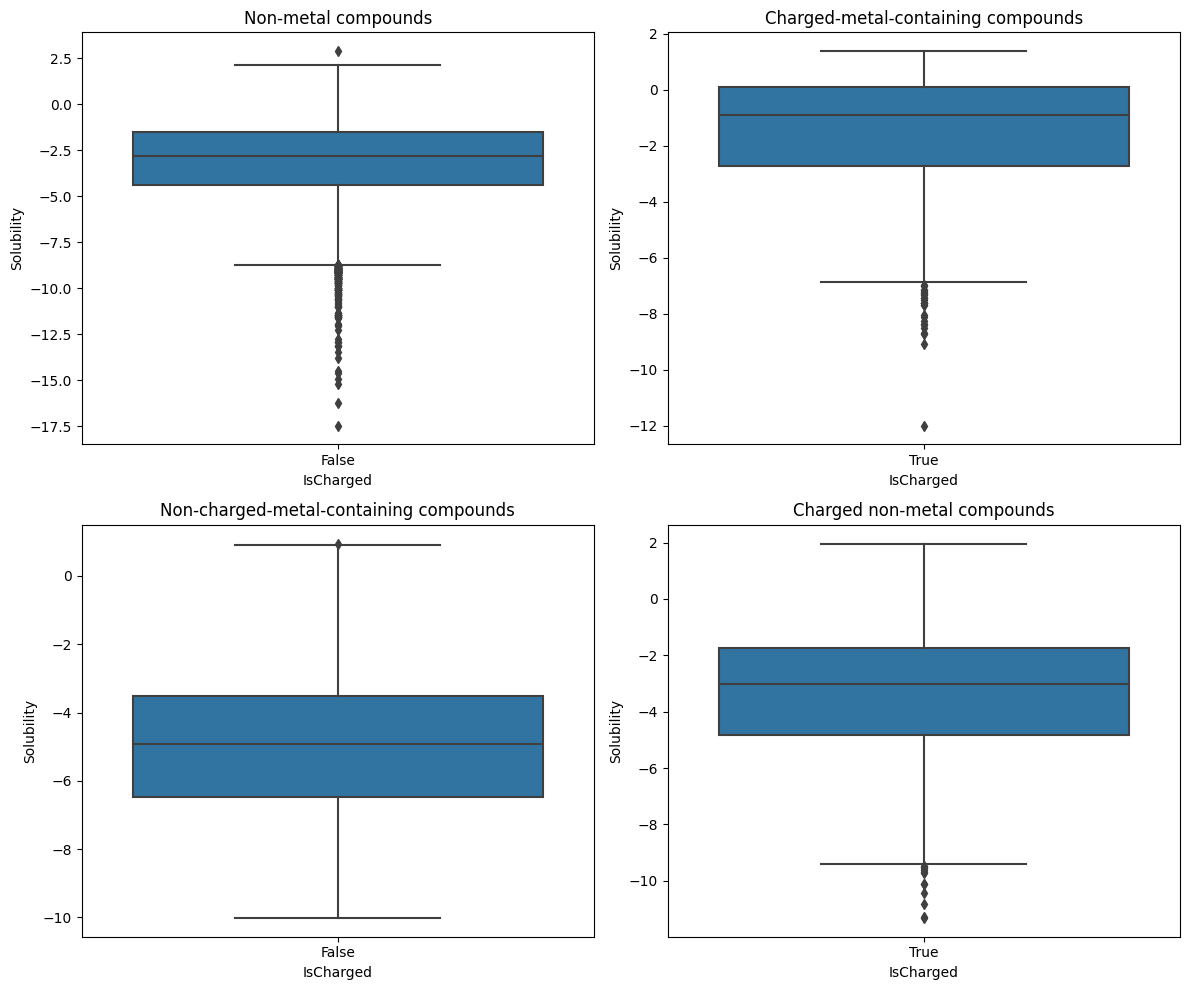

In [23]:
# Filter the DataFrame for non-metal compounds
non_metal_df = analyze_df[(analyze_df['HasMetal'] == False) & (analyze_df['IsCharged'] == False)]

# Filter the DataFrame for charged-metal-containing compounds
charged_metal_df = analyze_df[(analyze_df['HasMetal'] == True) & (analyze_df['IsCharged'] == True)]

# Filter the DataFrame for non-charged-metal-containing compounds
non_charged_metal_df = analyze_df[(analyze_df['HasMetal'] == True) & (analyze_df['IsCharged'] == False)]

# Filter the DataFrame for charged compounds
charged_nonmetal_df = analyze_df[(analyze_df['HasMetal'] == False) & (analyze_df['IsCharged'] == True)]

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot for non-metal compounds
sns.boxplot(x='IsCharged', y='Solubility', data=non_metal_df, ax=axes[0, 0])
axes[0, 0].set_title('Non-metal compounds')

# Plot for charged-metal-containing compounds
sns.boxplot(x='IsCharged', y='Solubility', data=charged_metal_df, ax=axes[0, 1])
axes[0, 1].set_title('Charged-metal-containing compounds')

# Plot for non-charged-metal-containing compounds
sns.boxplot(x='IsCharged', y='Solubility', data=non_charged_metal_df, ax=axes[1, 0])
axes[1, 0].set_title('Non-charged-metal-containing compounds')

# Plot for charged non-metal compounds
sns.boxplot(x='IsCharged', y='Solubility', data=charged_nonmetal_df, ax=axes[1, 1])
axes[1, 1].set_title('Charged non-metal compounds')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

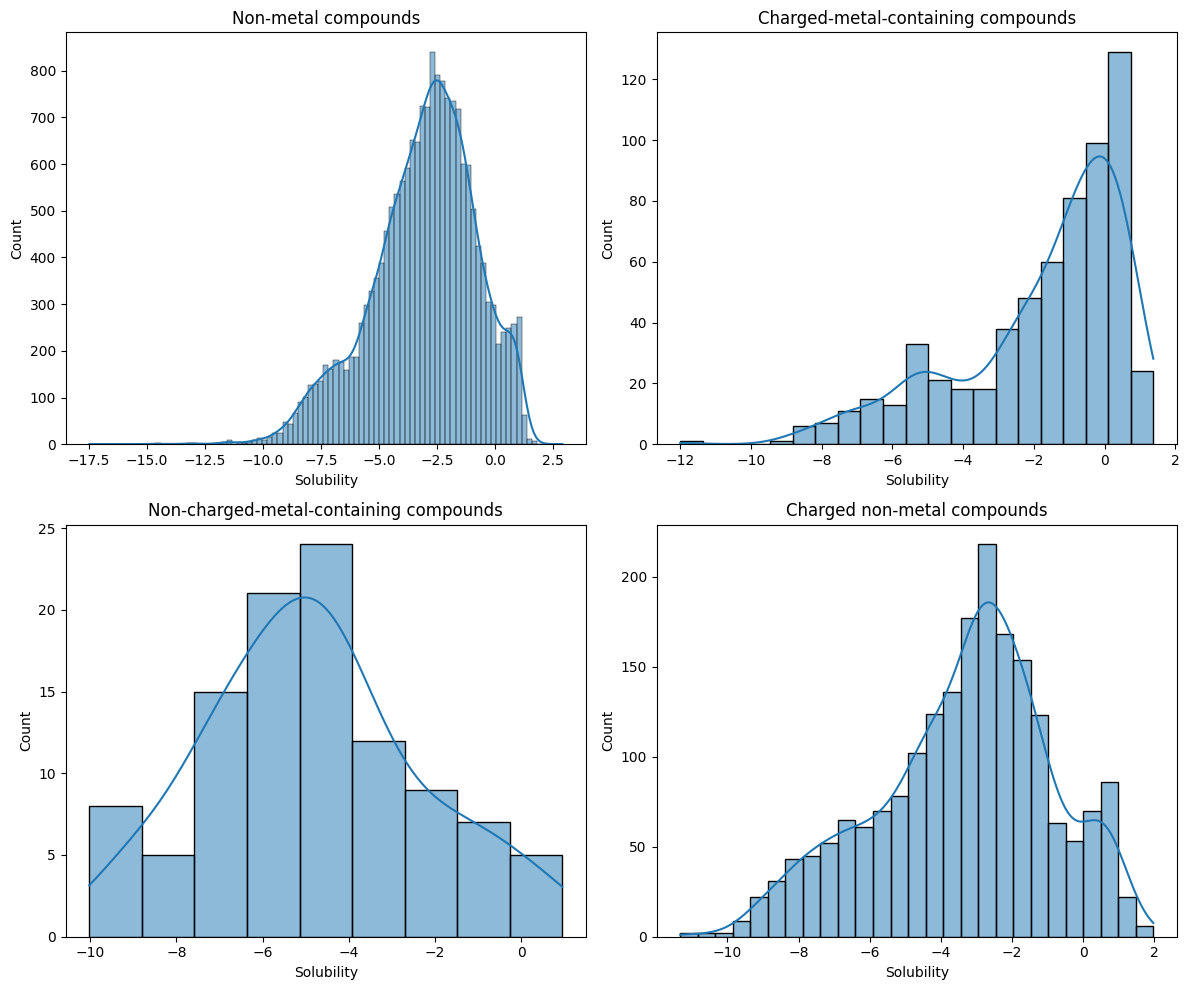

In [24]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot histogram for non-metal compounds
sns.histplot(data=non_metal_df, x='Solubility', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Non-metal compounds')

# Plot histogram for charged-metal-containing compounds
sns.histplot(data=charged_metal_df, x='Solubility', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Charged-metal-containing compounds')

# Plot histogram for non-charged-metal-containing compounds
sns.histplot(data=non_charged_metal_df, x='Solubility', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Non-charged-metal-containing compounds')

# Plot histogram for charged non-metal compounds
sns.histplot(data=charged_nonmetal_df, x='Solubility', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Charged non-metal compounds')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

We can see that compounds behave differently in terms of solubility based on charge and the existence of metal atom, and the number of non-metal compounds are way more compared to the rest. Therefore, we should do stratified sampling based on the charge and the existence of metal atom when splitting the dataset to training, validation, and test set. 

In [8]:
from sklearn.model_selection import train_test_split

# Perform 70:15:15 split with stratification\
features = analyze_df.drop(columns=[SOLUBILITY])
target = analyze_df[SOLUBILITY]

# List all the columns needed to be stratified
stratify_cols = ['IsCharged', 'HasMetal']

# Perform 70:15:15 split with stratification\
features = analyze_df.drop(columns=[SOLUBILITY])
target = analyze_df[SOLUBILITY]
X_train, X_remaining, y_train, y_remaining = train_test_split(features, target, test_size=0.3, 
                                                                                random_state=RANDOM_SEED, stratify=analyze_df[stratify_cols])
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5,
                                                                random_state=RANDOM_SEED, stratify=analyze_df.loc[X_remaining.index, stratify_cols])

X_train = X_train.drop(columns=stratify_cols)
X_val = X_val.drop(columns=stratify_cols)
X_test = X_test.drop(columns=stratify_cols)

In [9]:
print(f"Printing training dataset size: {len(X_train)}")
print(f"Printing validation dataset size: {len(X_val)}")
print(f"Printing test dataset size: {len(X_test)}")

Printing training dataset size: 14619
Printing validation dataset size: 3133
Printing test dataset size: 3133


Now, we can start training!

# Model Training

First we will do some imports and
1. Drop SMILES from the features
2. Scale the features
3. By default, 819 features are used
4. Cross-Validation used will be 5-folds

The Mean Squared Error (MSE) will be used as the loss function. The model's performance can be evaluated based on Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and the number of predictions within an offset of 0.5 log units, as this range represents the experimental value error for solubility.

In [200]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, KFold
from sklearn.ensemble import RandomForestRegressor

from functools import reduce

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
X_train_copy = X_train.copy(True).drop(columns=[SMILES_SOLUTE])
X_val_copy = X_val.copy(True).drop(columns=[SMILES_SOLUTE])
X_test_copy = X_test.copy(True).drop(columns=[SMILES_SOLUTE])

# Normalize input features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_copy)
X_val_scaled = scaler_X.transform(X_val_copy)
X_test_scaled = scaler_X.transform(X_test_copy)

input_shape = X_train_scaled.shape[1]

# Cross-Validation
num_folds = 5
def plot_learning_curve(model, fit_params=None):
    # Specify the training set sizes for learning curve
    train_sizes = np.linspace(0.1, 1.0, 5)

    # Calculate learning curve scores
    train_sizes, train_scores, valid_scores = learning_curve(model, X_train_scaled, y_train,
                                                            train_sizes=train_sizes, cv=num_folds,
                                                            scoring='neg_mean_squared_error', random_state=RANDOM_SEED, n_jobs=6,
                                                            fit_params=fit_params)

    # Calculate mean and standard deviation of the scores
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    # Plot the learning curve
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, valid_scores_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

# Define custom scoring functions for MSE and MAE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

def evaluate_model(predictions_test, expected_test):
    # Calculate MSE and MAE for the predictions
    mse_test = mean_squared_error(expected_test, predictions_test)
    mae_test = mean_absolute_error(expected_test, predictions_test)
    r2_test = r2_score(expected_test, predictions_test)

    # Calculate predictions within an offset of 0.5 log units
    absolute_diff = np.abs(predictions_test.ravel() - expected_test.ravel())
    within_offset_count = np.sum(absolute_diff <= 0.5)
    within_offset_percentage = (within_offset_count / len(expected_test)) * 100
    
    print(f"RMSE: {np.sqrt(mse_test)}")
    print(f"MAE: {mae_test}")
    print(f"R2: {r2_test}")
    print(f"Number of predictions within an offset of 0.5 log units: {within_offset_count}")
    print(f"Percentage of predictions within an offset of 0.5 log units: {within_offset_percentage}%")

### 1. Neural Network

The architecture of the neural network is a sequential network with the following layers and properties:
1. **Input Layer**:
   - One input linear layer (Dense layer) with the specified number of nodes (`hidden_layer_nodes1`).
   - Input shape is determined by the parameter `input_shape` passed to the function.
2. **Layer Normalization**:
   - A LayerNormalization layer is added to normalize the activations of the previous layer.
3. **Hidden Layers**:
   - Three hidden layers (Dense layers) with the specified number of nodes (`hidden_layer_nodes2` and `hidden_layer_nodes3`).
   - Each hidden layer uses the ReLU activation function, which introduces non-linearity into the network.
4. **Regularization**:
   - L1 and L2 regularization are applied to the weights of the hidden layers using `regularizers.l1_l2`.
   - The strengths of L1 and L2 regularization are controlled by the parameters `l1_strength` and `l2_strength` respectively.
5. **Dropout**:
   - Three Dropout layers are added after each hidden layer.
   - Dropout is a regularization technique that randomly drops out a fraction of the nodes during training, helping prevent overfitting especially with high number of features used.
6. **Output Layer**:
   - One output linear layer (Dense layer) with a single node for regression tasks (i.e., predicting a continuous value).
   - The activation function for the output layer is 'linear', which means the network predicts a continuous value directly.
7. **Compilation**:
   - The model is compiled using the mean squared error (MSE) as the loss function.
   - The optimizer used is Adam.
   - The learning rate is set based on the provided value for `learning_rate`.

Additionally, it will also have an `EarlyStopping` callbacks to stop early when there is no improvement in terms of validation loss after 5 epochs.

The parameters are searched using `RandomizedSearchCV`.

The following functions are used to run experiments:

In [32]:
# Define creation of neural network model
def create_nn_model(hidden_layer_nodes1, hidden_layer_nodes2, hidden_layer_nodes3,
                 learning_rate, l1_strength, l2_strength, dropout_rate):
    model = Sequential()
    model.add(LayerNormalization())
    model.add(Dense(hidden_layer_nodes1, activation='relu', input_shape=(input_shape,),
                    kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_layer_nodes2, activation='relu',
                    kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_layer_nodes3, activation='relu',
                    kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Main experiment function
def run_experiment_nn(num_runs, param_grid, log_file_path, best_model_path, dump_pkl_path, callbacks=None):
    for i in range(num_runs):
        all_results = []
        # Maximum 10 iterations of search
        n_iterations = min(10, reduce(lambda x, y: x * len(y), param_grid.values(), 1))
        try:
            with open(log_file_path, "a") as log_file:    
                log_file.write("===================================================\n")

            # For each feature set, perform hyperparameter optimization and calculate MSE and MAE
            model = KerasRegressor(build_fn=create_nn_model, verbose=0)
            grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, random_state=RANDOM_SEED,
                                        n_iter=n_iterations, cv=num_folds, n_jobs=6, scoring={'neg_mean_squared_error': mse_scorer,
                                                                        'neg_mean_absolute_error': mae_scorer}, return_train_score=True, refit='neg_mean_squared_error', verbose=0)
            grid_result = grid.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), callbacks=callbacks)

            # Get the best model from the hyperparameter optimization
            cur_best_model = grid_result.best_estimator_.model
            
            # Get the index of the best hyperparameter combination
            val_best_index = grid_result.best_index_

            # Get the best MSE and MAE from the cv_results_
            val_best_mse = -grid_result.cv_results_["mean_test_neg_mean_squared_error"][val_best_index]
            val_best_mae = -grid_result.cv_results_["mean_test_neg_mean_absolute_error"][val_best_index]
            
            cv_results = grid_result.cv_results_
            for mean_mse, std_mse, mean_mae, std_mae, params in zip(cv_results["mean_test_neg_mean_squared_error"],
                                                                    cv_results["std_test_neg_mean_squared_error"],
                                                                    cv_results["mean_test_neg_mean_absolute_error"],
                                                                    cv_results["std_test_neg_mean_absolute_error"],
                                                                    cv_results["params"]):
                with open(log_file_path, "a") as log_file:
                    log_file.write(f"Mean MSE: {-mean_mse:.4f}, Std MSE: {std_mse:.4f}, "
                        f"Mean MAE: {-mean_mae:.4f}, Std MAE: {std_mae:.4f}, Params: {params}\n")
            
            
            # Log the best result and model
            with open(log_file_path, "a") as log_file:    
                log_file.write("\nHowever the best result is\n")
                log_file.write(f"Run {i} - Best MSE: {val_best_mse:.4f}, Best MAE: {val_best_mae:.4f}, Params: {grid_result.best_params_}\n")
            
            all_results.append((cur_best_model, val_best_mse, val_best_mae))
            
        except Exception as e:
            with open(log_file_path, "a") as log_file:    
                log_file.write(f"An ERROR OCCURED at iteration {i} with error : {str(e)}\n")
        finally:
            with open(log_file_path, "a") as log_file:    
                log_file.write("===================================================\n")
            joblib.dump(all_results, dump_pkl_path)
            
    best_model, best_mse, best_mae = min(all_results, key=lambda x: x[1])  # Get the model with the lowest MSE
    print("Val Best MSE:", best_mse)
    print("Val Best MAE:", best_mae)
    with open(log_file_path, "a") as log_file:    
        log_file.write(f"\nBest out of the best has MSE {best_mse} and MAE {best_mae}\n")
        log_file.write(json.dumps(best_model.get_config(), indent=2))  # Save best_best_model's parameters as JSON
        
    # Save the best model to a file
    save_model(best_model, best_model_path)
    
    return best_model

You can run the following code to do some experiments:

In [86]:
# Paths to save files
nn_path = os.path.join(DIR_PATH, f"{MODELS_DIR_NAME}/neural_network")
nn_log_path = os.path.join(nn_path, "nn_hyperparam_results.log")
nn_best_model_path = os.path.join(nn_path, "nn_best_model.h5")
nn_dump_pkl_path = os.path.join(nn_path, "nn_hyperparam_results.pkl")

if not os.path.exists(nn_path):
    os.makedirs(nn_path)

In [25]:
num_runs = 1

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)
callbacks = [early_stopping]

# Parameters to search upon
nn_param_grid = {
    'hidden_layer_nodes1': [64, 128, 256],
    'hidden_layer_nodes2': [48, 96, 128],
    'hidden_layer_nodes3': [32, 64, 80],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'l1_strength': [0.0, 0.0001, 0.00001, 0.000001],
    'l2_strength': [0.0, 0.0001, 0.00001, 0.000001],
    'dropout_rate': [0.0, 0.01, 0.0001],
    'batch_size': [16, 32]
}

my_best_nn_model = run_experiment_nn(num_runs, nn_param_grid, nn_log_path, nn_best_model_path, nn_dump_pkl_path, callbacks)

Since we had run the experiments multiple times due to nature of `RandomizedSearchCV`, there are some other combinations that we have tried.
You can simply follow the following code where we will be using the parameters that worked the best for me.
In addition, the following code provides a simplification on how does the whole process without additional logging:
1. Apply 5-folds cross validation to the training set.
2. Plot the training curve based on the epoch.
3. Additionally evaluate an external validation set to compare between models.

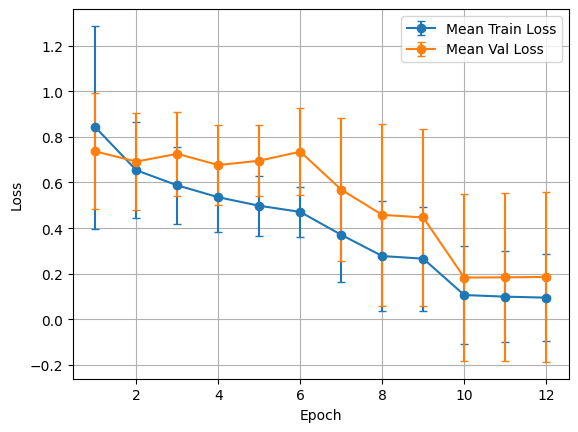

In [83]:
# Initialize lists to store training and validation loss for each row fold and column epochs
train_losses = []
val_losses = []

# Create a new instance of the model for each fold to start with fresh weights
my_best_nn_model = create_nn_model(hidden_layer_nodes1=256,
                        hidden_layer_nodes2=128,
                        hidden_layer_nodes3=80,
                        learning_rate=0.0005,
                        l1_strength=1e-5,
                        l2_strength=1e-5,
                        dropout_rate=0)

# Iterate over the folds and perform cross-validation
for fold, (train_idx, val_idx) in enumerate(cross_validator.split(X_train_scaled)):
    X_train_fold, X_val_fold = X_train_scaled.take(train_idx, axis=0), X_train_scaled.take(val_idx, axis=0)
    y_train_fold, y_val_fold = y_train.take(train_idx, axis=0), y_train.take(val_idx, axis=0)
    
    # Train the best model on the current fold
    history = my_best_nn_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), batch_size=32, epochs=100, callbacks=callbacks, verbose=0)

    # Get the training and validation loss from the history object
    train_losses.append(np.array(history.history['loss'], dtype='float32'))
    val_losses.append(np.array(history.history['val_loss'], dtype='float32'))

# Convert the lists to numpy arrays for easier computation
train_losses = np.array(train_losses, dtype='object')
val_losses = np.array(val_losses, dtype='object')

# Pad the training and validation loss arrays for each fold to have the same length (as num epochs may be different)
train_losses = pad_sequences(train_losses, dtype='float32', padding='post')
val_losses = pad_sequences(val_losses, dtype='float32', padding='post')

# Calculate the mean and standard deviation of training and validation loss over all folds at each epoch
mean_train_losses = np.mean(train_losses, axis=0)
std_train_losses = np.std(train_losses, axis=0)
mean_val_losses = np.mean(val_losses, axis=0)
std_val_losses = np.std(val_losses, axis=0)

# Plot the training curve
epochs = range(1, len(mean_train_losses) + 1)
plt.errorbar(epochs, mean_train_losses, yerr=std_train_losses, label='Mean Train Loss', marker='o', linestyle='-', capsize=3)
plt.errorbar(epochs, mean_val_losses, yerr=std_val_losses, label='Mean Val Loss', marker='o', linestyle='-', capsize=3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Another validation set is provided to compare between models just in case the cross-validation introduces bias and overfits. However, since we had already compared models previously, this would seem like a _duplicated_ test set.

In [117]:
# Make predictions on validation set using the best RandomForestRegressor model
predictions_val = my_best_nn_model.predict(X_val_scaled)
evaluate_model(predictions_val, y_val)

98/98 [==============================] - 1s 5ms/step
RMSE: 0.8595185643317627
MAE: 0.5479520085322767
R2: 0.8672540080221991
Number of predictions within an offset of 0.5 log units: 1958
Percentage of predictions within an offset of 0.5 log units: 62.496010213852536%


Save the neural network model if needed.

In [ ]:
# Save the model if you'd like to
save_model(my_best_nn_model, nn_best_model_path)

Time to actually evaluate the neural network model using the test set.

In [118]:
# Make predictions using the best neural network model
predictions_test = my_best_nn_model.predict(X_test_scaled)
evaluate_model(predictions_test, y_test)

98/98 [==============================] - 0s 5ms/step
RMSE: 0.852324655635887
MAE: 0.5589360806066678
R2: 0.8608928238230693
Number of predictions within an offset of 0.5 log units: 1952
Percentage of predictions within an offset of 0.5 log units: 62.30450047877434%


The test RMSE should be between 0.85 to 0.86 log unit, which is quite a competitive result.

### 2. RandomForestRegressor

`RandomForestRegressor` model will have the following hyperparameters being searched using `RandomizedSearchCV`:
- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `max_features`: The number of features to consider when looking for the best split.
- `bootstrap`: Whether bootstrap samples are used when building trees.

The following codes are main functions for running experiments:

In [174]:
rf_default_params = {"random_state": RANDOM_SEED}

# Define the RandomForestRegressor model
def create_rf_model(n_estimators, max_depth, min_samples_split,
                             min_samples_leaf, max_features, bootstrap):
    return RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, **rf_default_params)

# Main experiment function for RandomForest
def run_experiment_rf(num_runs, param_grid, log_file_path, best_model_path, dump_pkl_path):
    all_results = []
    
    for i in range(num_runs):
        try:
            with open(log_file_path, "a") as log_file:    
                log_file.write("===================================================\n")

            # Maximum 10 iterations of search
            n_iterations = min(10, reduce(lambda x, y: x * len(y), param_grid.values(), 1))
            
            # For each feature set, perform hyperparameter optimization and calculate MSE and MAE
            grid = RandomizedSearchCV(estimator=RandomForestRegressor(**rf_default_params), param_distributions=param_grid,
                                        n_iter=n_iterations, cv=num_folds, n_jobs=6, scoring='neg_mean_squared_error', verbose=0)
            grid_result = grid.fit(X_train_scaled, y_train)

            # Get the best model from the hyperparameter optimization
            cur_best_model = grid_result.best_estimator_
            val_predictions = cur_best_model.predict(X_val_scaled)
            val_mse = mean_squared_error(y_val, val_predictions)
            val_mae = mean_absolute_error(y_val, val_predictions)
            
            # Get the index of the best hyperparameter combination
            cv_best_index = grid_result.best_index_
            cv_best_mse = -grid_result.cv_results_["mean_test_score"][cv_best_index]
            
            cv_results = grid_result.cv_results_
            for mean_mse, std_mse, params in zip(cv_results["mean_test_score"],
                                                 cv_results["std_test_score"],
                                                 cv_results["params"]):
                with open(log_file_path, "a") as log_file:
                    log_file.write(f"Mean MSE: {-mean_mse:.4f}, Std MSE: {std_mse:.4f}, "
                        f"Params: {params}\n")
            
            
            # Log the best result and model
            with open(log_file_path, "a") as log_file:    
                log_file.write("\nHowever the best result is\n")
                log_file.write(f"Run {i} - Best MSE: {cv_best_mse:.4f}, - Validation MSE: {val_mse:.4f}, - Validation MAE: {val_mae:.4f}, Params: {grid_result.best_params_}\n")
            
            all_results.append((cur_best_model, val_mse, val_mae))
            
        except Exception as e:
            with open(log_file_path, "a") as log_file:    
                log_file.write(f"An ERROR OCCURED at iteration {i} with error : {str(e)}\n")
        finally:
            with open(log_file_path, "a") as log_file:    
                log_file.write("===================================================\n")
            joblib.dump(all_results, dump_pkl_path)
            
            
    best_model, best_mse, best_mae = min(all_results, key=lambda x: x[1])  # Get the model with the lowest MSE
    print("RMSE of best model on validation set:", np.sqrt(best_mse))
    with open(log_file_path, "a") as log_file:    
        log_file.write(f"\nBest model has MSE {best_mse} and MAE {best_mae}\n")
        
    # Save the best model to a file
    joblib.dump(best_model, best_model_path)
    
    return best_model

You can run your own experiments by running these code:

In [175]:
rf_path = os.path.join(DIR_PATH, f"{MODELS_DIR_NAME}/random_forest")
rf_log_path = os.path.join(rf_path, "rf_hyperparam_results.log")
rf_best_model_path = os.path.join(rf_path, "rf_best_model.pkl")
rf_dump_pkl_path = os.path.join(rf_path, "rf_hyperparam_results.pkl")

if not os.path.exists(rf_path):
    os.makedirs(rf_path)

In [176]:
num_runs = 1

rf_param_grid = {
    'n_estimators': [300, 350, 400],
    'max_depth': [20, 25, 30, 35, 40],
    'min_samples_split': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
}

my_best_rf_model = run_experiment_rf(num_runs, rf_param_grid, rf_log_path, rf_best_model_path, rf_dump_pkl_path)

RMSE of best model on validation set: 0.8305020360313806


Due to the nature of `RandomizedSearchCV`, we had run the experiments multiple times, so there are some other combinations that we have tried.
You can simply run the experiment above with `num_runs=1` and tune your own hyperparameters if you would like to come up with your own set of optimized hyperparameters.
Now, we will plot the training curve during cross validation against training set size.

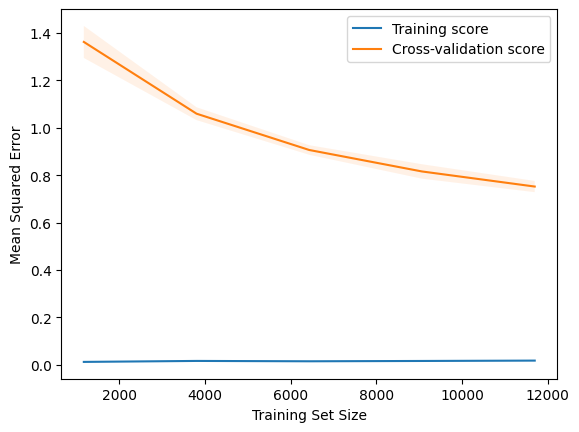

In [177]:
plot_learning_curve(my_best_rf_model)

We can check what are the top features that are important for our model.

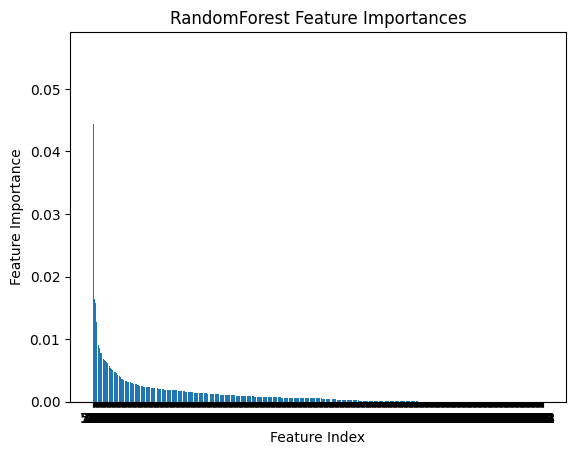

In [149]:
# Get the feature importances
feature_importances = my_best_rf_model.feature_importances_

# Sort feature importances in descending order
feat_indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure()
plt.bar(range(X_val_scaled.shape[1]), feature_importances[feat_indices])
plt.xticks(range(X_val_scaled.shape[1]), feat_indices)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('RandomForest Feature Importances')
plt.show()

In [150]:
num_top_features = 50

top_features_indices = feat_indices[:num_top_features]
top_features = [X_val.columns[i] for i in top_features_indices]
top_importances = [feature_importances[i] for i in top_features_indices]

# Print the top k features and their importances
print("Top {num_top_features} Important Features:")
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance}")

Top {num_top_features} Important Features:
nRot: 0.05624392278971372
GhoseFilter: 0.04433396133037055
PEOE_VSA5: 0.02165519903242441
ZMIC0: 0.01646951598063808
BertzCT: 0.01615802553613638
SLogP: 0.015718982055416695
nB: 0.013441258279761926
SlogP_VSA1: 0.01279342800128303
ATS0p: 0.012496871604297941
ATS1v: 0.011021798939450376
SMR: 0.009081987456747383
fr_urea: 0.009050033204227287
ATS0v: 0.008614415816490856
Xpc-6dv: 0.008344861695039884
NHOHCount: 0.007825348594098403
ATS8pe: 0.007782973580249549
AATS0p: 0.007738582198881806
Xp-2d: 0.00708403469711954
ATS8m: 0.00706379784158037
ZMIC5: 0.006816126850787044
WPol: 0.006641979292774753
SZ: 0.006609837921383832
TopoPSA(NO): 0.006528979579434449
MWC10: 0.006525683151986651
Radius: 0.0063831789475482644
ATS1p: 0.006377497698872034
piPC9: 0.0062836336725444995
MWC02: 0.006224918393943062
MWC01: 0.006167195711180214
MIC5: 0.006021226611657346
MPC9: 0.005695963196430218
fMF: 0.005510538540630956
ATS2p: 0.005424751462982396
SRW03: 0.0053160529

We had already compared models previously using this validation set, but we will print again.

In [187]:
# Make predictions on validation set using the best RandomForestRegressor model
predictions_val = my_best_rf_model.predict(X_val_scaled)
evaluate_model(predictions_val, y_val)

RMSE: 0.8305020360313806
MAE: 0.44536062316521413
R2: 0.8760654775358563
Number of predictions within an offset of 0.5 log units: 2220
Percentage of predictions within an offset of 0.5 log units: 70.85860197893393%


Save the RandomForestRegressor model if needed

In [ ]:
# Save the model if you'd like to
joblib.dump(my_best_rf_model, rf_best_model_path)

Finally, we can evaluate our RandomForestRegressor model using the test set.

In [188]:
# Make predictions on test set using the best RandomForestRegressor model
predictions_test = my_best_rf_model.predict(X_test_scaled)
evaluate_model(predictions_test, y_test)

RMSE: 0.8415349158354446
MAE: 0.46266439305402646
R2: 0.8643924995508819
Number of predictions within an offset of 0.5 log units: 2203
Percentage of predictions within an offset of 0.5 log units: 70.31599106287904%


The test RMSE should be between 0.84 to 0.85 log unit, which is slightly better than the neural network model

### 3. XGBoostRegressor

`XGBoostRegressor` model will have the following hyperparameters being searched using `RandomizedSearchCV`:
- `n_estimators`: The number of trees in the XGBoost model (equivalent to the number of boosting rounds).
- `max_depth`: The maximum depth of each tree in the XGBoost model.
- `learning_rate`: The learning rate (or step size) used in boosting. It controls the contribution of each tree to the final prediction.
- `subsample`: The fraction of samples used for fitting the individual trees. This parameter helps prevent overfitting.
- `colsample_bytree`: The fraction of features (columns) used for fitting each tree. This parameter helps prevent overfitting.

The following codes are main functions for running experiments:

In [216]:
xgb_default_params = {"random_state": RANDOM_SEED, "early_stopping_rounds": 10}

# Define custom XGB Model
def create_xgb_model(n_estimators, max_depth, learning_rate,
                     subsample, colsample_bytree):
    return xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth,
                            learning_rate=learning_rate, subsample=subsample,
                            colsample_bytree=colsample_bytree, **xgb_default_params)

# Main experiment function for XGB
def run_experiment_xgb(num_runs, param_grid, log_file_path, best_model_path, dump_pkl_path):
    all_results = []

    for i in range(num_runs):
        try:
            with open(log_file_path, "a") as log_file:    
                log_file.write("===================================================\n")

            # Maximum 10 iterations of search
            n_iterations = min(12, reduce(lambda x, y: x * len(y), param_grid.values(), 1))

            # For each feature set, perform hyperparameter optimization and calculate MSE and MAE
            grid = RandomizedSearchCV(estimator=xgb.XGBRegressor(**xgb_default_params), param_distributions=param_grid,
                                      n_iter=n_iterations, cv=num_folds, n_jobs=6, scoring={'neg_mean_squared_error': mse_scorer,
                                                                    'neg_mean_absolute_error': mae_scorer}, return_train_score=True, refit='neg_mean_squared_error', verbose=0)
            grid_result = grid.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)])

            # Get the best model from the hyperparameter optimization
            cur_best_model = grid_result.best_estimator_
            
            # Get the index of the best hyperparameter combination
            val_best_index = grid_result.best_index_

            # Get the best MSE and MAE from the cv_results_
            val_best_mse = -grid_result.cv_results_["mean_test_neg_mean_squared_error"][val_best_index]
            val_best_mae = -grid_result.cv_results_["mean_test_neg_mean_absolute_error"][val_best_index]
            
            cv_results = grid_result.cv_results_
            for mean_mse, std_mse, mean_mae, std_mae, params in zip(cv_results["mean_test_neg_mean_squared_error"],
                                                                    cv_results["std_test_neg_mean_squared_error"],
                                                                    cv_results["mean_test_neg_mean_absolute_error"],
                                                                    cv_results["std_test_neg_mean_absolute_error"],
                                                                    cv_results["params"]):
                with open(log_file_path, "a") as log_file:
                    log_file.write(f"Mean MSE: {-mean_mse:.4f}, Std MSE: {std_mse:.4f}, "
                        f"Mean MAE: {-mean_mae:.4f}, Std MAE: {std_mae:.4f}, Params: {params}\n")
            
            
            # Log the best result and model
            with open(log_file_path, "a") as log_file:    
                log_file.write("\nHowever the best result is\n")
                log_file.write(f"Run {i} - Best MSE: {val_best_mse:.4f}, Best MAE: {val_best_mae:.4f}, Params: {grid_result.best_params_}\n")
            
            all_results.append((cur_best_model, val_best_mse, val_best_mae))

        except Exception as e:
            with open(log_file_path, "a") as log_file:    
                log_file.write(f"An ERROR OCCURED at iteration {i} with error : {str(e)}\n")
        finally:
            with open(log_file_path, "a") as log_file:    
                log_file.write("===================================================\n")
            joblib.dump(all_results, dump_pkl_path)

    best_model, best_mse, best_mae = min(all_results, key=lambda x: x[1])  # Get the model with the lowest MSE
    print("Val Best MSE:", best_mse)
    print("Val Best MAE:", best_mae)
    with open(log_file_path, "a") as log_file:    
        log_file.write(f"\nBest out of the best has MSE {best_mse} and MAE {best_mae}\n")

    # Save the best model to a file
    joblib.dump(best_model, best_model_path)
    
    return best_model

You can run your own experiments by running these code:

In [217]:
xgb_path = os.path.join(DIR_PATH, f"{MODELS_DIR_NAME}/xgboost")
xgb_log_path = os.path.join(xgb_path, "xgb_hyperparam_results.log")
xgb_best_model_path = os.path.join(xgb_path, "xgb_best_model.pkl")
xgb_dump_pkl_path = os.path.join(xgb_path, "xgb_hyperparam_results.pkl")

if not os.path.exists(xgb_path):
    os.makedirs(xgb_path)

In [ ]:
num_runs = 5

xgb_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
}

my_best_xgb_model = run_experiment_xgb(num_runs, xgb_param_grid, xgb_log_path, xgb_best_model_path, xgb_dump_pkl_path)

Due to the nature of `RandomizedSearchCV`, we had run the experiments multiple times, so there are some other combinations that we have tried.
You can simply run the experiment above with `num_runs=1` and tune your own hyperparameters if you would like to come up with your own set of optimized hyperparameters.
Now, we will plot the training curve during cross validation against training set size.

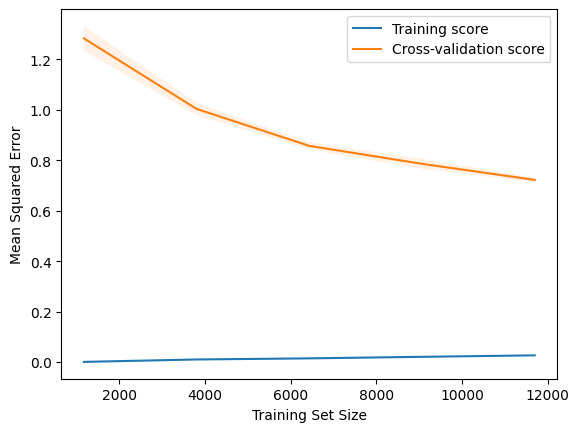

In [208]:
plot_learning_curve(my_best_xgb_model)

Another validation set is provided to compare between models just in case the cross-validation introduces bias and overfits. However, since we had already compared models previously, this would seem like a _duplicated_ test set.

In [209]:
# Make predictions on validation set using the best XGBoostRegressor model
predictions_val = my_best_xgb_model.predict(X_val_scaled)
evaluate_model(predictions_val, y_val)

RMSE: 0.8208557301001894
MAE: 0.45858766913799515
R2: 0.8789277640169085
Number of predictions within an offset of 0.5 log units: 2248
Percentage of predictions within an offset of 0.5 log units: 71.75231407596553%


Save the XGBoostRegressor model if needed

In [ ]:
# Save the model if you'd like to
joblib.dump(my_best_xgb_model, xgb_best_model_path)

Finally, we can evaluate our XGBoostRegressor model using the test set.

In [210]:
# Make predictions on test set using the best XGBoostRegressor model
predictions_test = my_best_xgb_model.predict(X_test_scaled)
evaluate_model(predictions_test, y_test)

RMSE: 0.817451951720609
MAE: 0.4661557957843199
R2: 0.8720430435655864
Number of predictions within an offset of 0.5 log units: 2249
Percentage of predictions within an offset of 0.5 log units: 71.78423236514523%


The test RMSE should be between 0.81 to 0.83 log unit, which is slightly better than the RandomForestRegressor model

# Models Summary and Conclusion

In this study, we evaluated three different models for predicting solubility (logS) of chemical compounds: a Neural Network model, a RandomForestRegressor, and an XGBoostRegressor. Below is a summary of the results obtained from each model on the test set:

### Neural Network Model
- **Root Mean Squared Error (RMSE):** 0.8523
- **Mean Absolute Error (MAE):** 0.5589
- **Coefficient of Determination ($R^2$):** 0.8609
- **Percentage of predictions within an offset of 0.5 log units:** 62.3%

### RandomForestRegressor Model
- **Root Mean Squared Error (RMSE):** 0.8415
- **Mean Absolute Error (MAE):** 0.4627
- **Coefficient of Determination ($R^2$):** 0.8644
- **Percentage of predictions within an offset of 0.5 log units:** 70.32%

### XGBoostRegressor Model
- **Root Mean Squared Error (RMSE):** 0.8175
- **Mean Absolute Error (MAE):** 0.4662
- **Coefficient of Determination ($R^2$):** 0.872
- **Percentage of predictions within an offset of 0.5 log units:** 71.78%

Based on the test set performance, the RandomForestRegressor model slightly outperformed the Neural Network model in all evaluation metrics. The RandomForestRegressor model achieved a lower RMSE and MAE, indicating better accuracy in predicting solubility values. Additionally, the $R^2$ value suggests that the RandomForestRegressor model explains a higher proportion of the variance in the data compared to the Neural Network model.

One possible explanation for the RandomForestRegressor's performance is that the relationship between some of the input features and solubility might be relatively simple or linear, and RandomForestRegressor is capable of capturing such relationships effectively. Moreover, the RandomForestRegressor is robust to outliers, which could be beneficial when dealing with data that contains extreme values. Outliers can be observed based on the boxplot and histograms plotted during Exploratory Data Analysis (EDA).

The XGBoostRegressor model also slightly outperformed the RandomForestRegressor model. The XGBoostRegressor model achieved a lower RMSE and a higher $R^2$ value; however, it is slightly worse in terms of MAE.

One possible explanation for the XGBoostRegressor's performance is that there are input features that may have a non-linear relationship with solubility, and XGBoostRegressor is capable of capturing such complex relationships effectively. Another factor contributing to its performance might be the use of gradient boosting technique, which allows the model to improve prediction accuracy based on previous models' weaknesses, and this is particularly useful when the datasets have some similarities in the test set.

# Model Comparison

For comparison, the performance of other models from related papers (benchmarks performed separately) are as follows:

**A. SolTransNet, a transformer-based model. ([Francoeur, P. G., & Koes, D. R. (2021). SolTranNet–A Machine Learning Tool for Fast Aqueous Solubility Prediction. Journal of Chemical Information and Modeling, 61(6), 2530-2536.](https://doi.org/10.1021/acs.jcim.1c00331))**

The paper mentions that their model may produce unstable predictions for salts, so we benchmarked two datasets with results of:
1. Test dataset with salt included:
- RMSE: 1.141
- MAE: 0.82
- $R^2$: 0.751
- Number of predictions within an offset of 0.5 log units: 1319
- Percentage of predictions within an offset of 0.5 log units: 42.10%

2. Test dataset without salt included:
- RMSE: 1.067
- MAE: 0.782
- $R^2$: 0.776
- Number of predictions within an offset of 0.5 log units: 1263
- Percentage of predictions within an offset of 0.5 log units: 43.00%

**B. A graph convolutional neural network, their best model. ([Conn, J. G. M., Carter, J. W., Conn, J. J. A., Subramanian, V., Baxter, A., Engkvist, O., Llinas, A., Ratkova, E. L., Pickett, S. D., McDonagh, J. L., & Palmer, D. S. (2023). Blinded Predictions and Post Hoc Analysis of the Second Solubility Challenge Data: Exploring Training Data and Feature Set Selection for Machine and Deep Learning Models. Journal of Chemical Information and Modeling, 63(4), 1099-1113.](https://doi.org/10.1021/acs.jcim.2c01189))**

Test result reported by the paper:
- RMSE: 0.86
- $R^2$: 0.54
- Percentage of predictions within an offset of 0.5 log units: 55%

# Potential Next Steps
- Perform more robust feature selection techniques, especially considering the large number of features used in the current models. Techniques like PCA (Principal Component Analysis) can be explored, but conducting in-depth Exploratory Data Analysis (EDA) for each feature might provide valuable insights.
- Conduct analysis to identify the most important features for each model. This analysis can help in selecting and calculating only the most relevant features, potentially leading to more efficient models without compromising predictive performance.
- Include solvation energy as a feature, as it is a critical property influencing solubility. The prediction of solvation energy can be accomplished using transfer learning techniques or by leveraging data from other relevant datasets.
- Explore and deploy more sophisticated graph-based models. Molecules have inherent structural properties that can be better captured by graph models. Investigating graph neural networks or other graph-based architectures may result in more accurate predictions of solubility.